In [18]:
import yfinance as yf
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
import pandas


nvda = yf.Ticker("NVDA")
nvda_data = nvda.history(period="5y")

df = nvda_data[["Close"]]
df.index = pandas.to_datetime(df.index.date)

df

,Close
2017-10-23,48.637711
2017-10-24,49.147289
2017-10-25,47.905506
2017-10-26,48.407665
2017-10-27,49.933937
...,...
2022-10-17,118.879997
2022-10-18,119.669998
2022-10-19,120.510002
2022-10-20,121.940002


In [28]:
train_df = df.iloc[:-30]
test_df = df.iloc[-30:]

In [29]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(train_df['Close'], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_df['Close'], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [32]:
auto = auto_arima(train_df['Close'], d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7224.630, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7224.419, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7223.560, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7223.400, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7222.772, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7225.108, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.926 seconds


In [33]:
auto.aic()

7222.771872222225

In [34]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
import numpy as np

model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test_df['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test_df['Close'], forecasts)}")
print(f"SMAPE: {smape(test_df, forecasts)}")

/opt/homebrew/Caskroom/miniconda/base/envs/dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean squared error: 20.811784382346858
SMAPE: 2.597820093968349


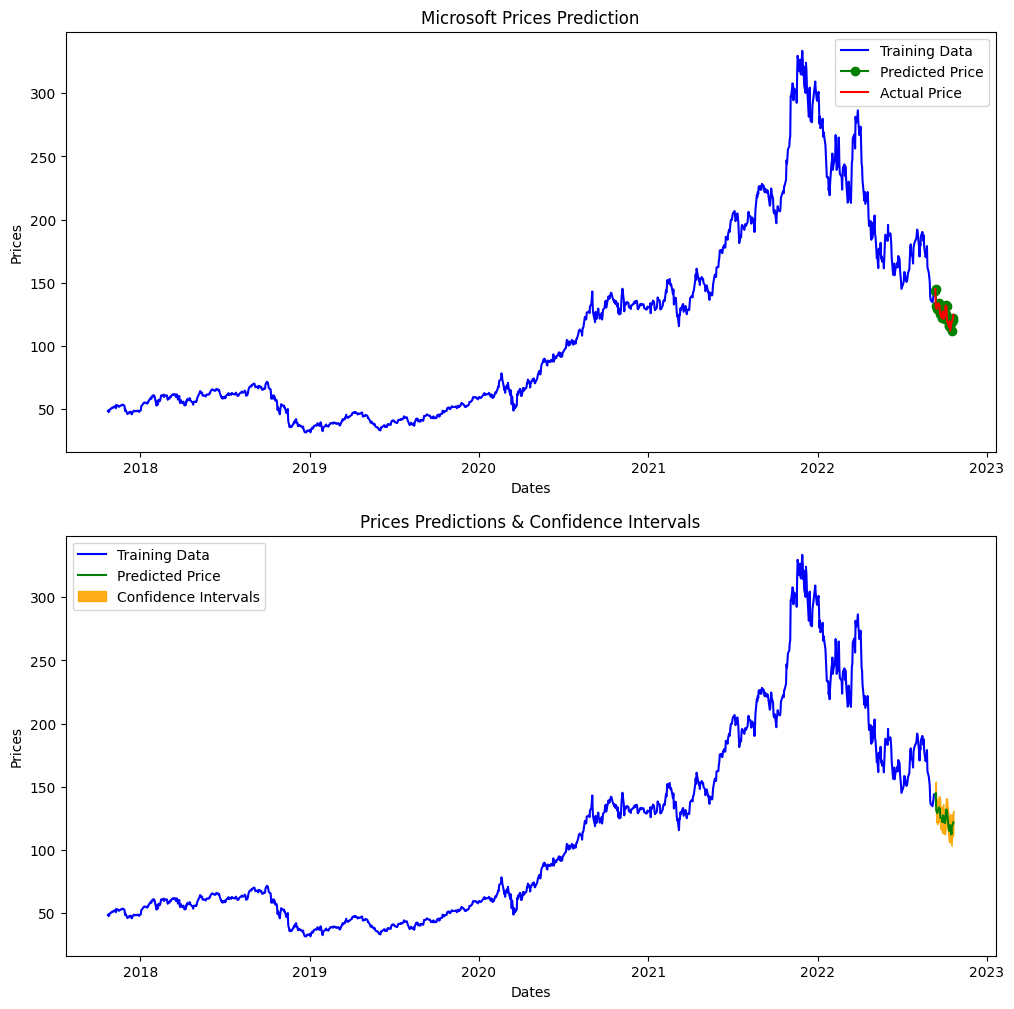

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

y_train = train_df['Close']
y_test = test_df['Close']

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_df.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_df.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Microsoft Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

# axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_df.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_df.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

# axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()

In [41]:
final = pd.DataFrame({'Actual': y_test, 'Predicted': forecasts})

final

,Actual,Predicted
2022-09-12,145.050003,143.869995
2022-09-13,131.309998,145.050003
2022-09-14,131.279999,131.309998
2022-09-15,129.289993,131.279999
2022-09-16,131.979996,129.289993
2022-09-19,133.820007,131.979996
2022-09-20,131.759995,133.820007
2022-09-21,132.610001,131.759995
2022-09-22,125.610001,132.610001
2022-09-23,125.160004,125.610001
